In [1]:
import cv2
print ("OpenCV", cv2.__version__)
import numpy as np
print ("Numpy", np.__version__)
from pma_python import core, pma
print ("PMA_python", pma.__version__)
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import itertools
from joblib import Parallel, delayed
from PIL import Image

OpenCV 3.4.1
Numpy 1.14.0
PMA_python 2.0.0.47


In [2]:
session = core.connect()
session

'SDK.Python'

In [3]:
folder = "C:/my_slides" 
# folder = "C:/Users/ovkul/Documents/Projects/Pathomation/"
slide = core.get_slides(folder)[0]
slide = "C:/my_slides/z_stack.czi"
num_z_stacks = core.get_number_of_layers(slide)
num_z_stacks

11

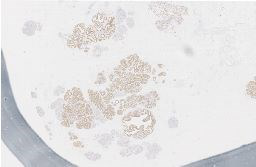

In [4]:
thumb = core.get_thumbnail_image(slide)
thumb

In [5]:
zoomlevels = core.get_zoomlevels_dict(slide)
sel_zl = int(round(len(zoomlevels) / 2)) + 2
max_x, max_y = zoomlevels[sel_zl][0], zoomlevels[sel_zl][1]

In [6]:
def get_z_stack(path, x, y, zoomlevel):
    z_stack = []
    for i in range(0, num_z_stacks):
        z_stack.append(core.get_tile(path, x, y, zoomlevel=zoomlevel, zstack=i))
    return z_stack

In [7]:
def determine_sharpest_tile(tiles):
    blur = []
    diff = []

    for idx in range(0, len(tiles)):
        blur.append(cv2.blur(np.array(tiles[idx]),(5,5)))
        diff.append(np.abs(blur[idx] - tiles[idx]))
        diff_sums = [np.sum(arr) for arr in diff]

    return tiles[diff_sums.index(np.max(diff_sums))]

In [9]:
def get_focused_tile(c):
    return determine_sharpest_tile(get_z_stack(slide, c[1], c[0], c[2]))

def get_focused_slide(slide, zoomlevel):
    x_count, y_count, n = core.get_number_of_tiles(slide, zoomlevel)
    x_tile_size, y_tile_size = core.get_tile_size()
    focused_tiles = []
    
    image = Image.new('RGB', (x_count * x_tile_size, y_count * y_tile_size))
    
    coords = list(map(lambda x: (x[0], x[1], zoomlevel), itertools.product(range(y_count), range(x_count))))

    tiles = Parallel(n_jobs=-1, verbose=2, backend="threading")(
             map(delayed(get_focused_tile), tqdm(coords)))
    
    i=0
    for y in range(y_count):
        for x in range(x_count):
            tile = tiles[i]
            i+=1
            image.paste(tile, (x*x_tile_size, y*y_tile_size))

    return image

In [18]:
image = get_focused_slide(slide, 6)

100%|██████████| 1944/1944 [47:28<00:00,  1.47s/it]
[Parallel(n_jobs=-1)]: Done 1944 out of 1944 | elapsed: 47.6min finished


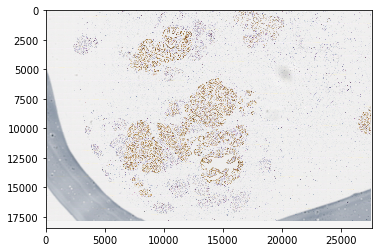

In [19]:
plt.imshow(image)
plt.show()

In [20]:
from PIL import features
print(features.check('libtiff'))

True


In [21]:
image.save('focused_image_6.tiff')